# Hidden state estimation (linear) using MLE/MAP analytic solutions and gradient descent

Demonstration of MLE/MAP estimation of the hidden state with a linear generating function using analytic solutions and gradient descent.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import sys
import torch

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.utils import create_agent, create_environment

mpl.style.use("seaborn-deep")

## Analytic hidden state estimation

### MLE solution

In [2]:
# Environment parameters
env_params = {
    "beta_0_star" : 3,    # Linear parameter intercept
    "beta_1_star" : 2,    # Linear parameter slope
    "y_star_std"  : 1e-5   # Standard deviation of sensory data
}

# Initialize environment
env = create_environment(name="static_linear", params=env_params)

# Generate data
x_range = np.linspace(start=0.01, stop=5, num=500)
x_star = 2

# Build environment and generate data
env.build(x_star)
y = env.generate()

In [3]:
# Agent parameters
agent_params = {
    "beta_0" : 3,    # Linear parameter intercept
    "beta_1" : 2,    # Linear parameter slope
}

agent = create_agent(name="linear_mle_agent", params=agent_params)

# Build model and infer states
agent.infer_state(y)
agent.store_history()

agent_history = agent.get_history()
posterior_mode = agent_history.posterior_mode

print(f'The posterior mode is {posterior_mode}. This is the most likely (expected) food size, the highest probability hidden state estimate, when the observed light intensity is 7.')

The posterior mode is 1.9999997026241472. This is the most likely (expected) food size, the highest probability hidden state estimate, when the observed light intensity is 7.


### MAP solution

In [4]:
# Agent parameters
agent_params = {
    "beta_0" : 3,    # Linear parameter intercept
    "beta_1" : 2,    # Linear parameter slope
    "m_x"    : 4,    # Prior mean
}

agent = create_agent(name="linear_map_agent", params=agent_params)

# Build model and infer states
agent.infer_state(y)
agent.store_history()

agent_history = agent.get_history()
posterior_mode = agent_history.posterior_mode

print(f'The posterior mode is {posterior_mode}. This is the most likely (expected) food size, the highest probability hidden state estimate, when the observed light intensity is 7.')

The posterior mode is 2.3999997620993176. This is the most likely (expected) food size, the highest probability hidden state estimate, when the observed light intensity is 7.


## Gradient descent hidden state estimation

In [5]:
# Initialize environment and agent
env = create_environment(name="static_linear", params=env_params)

# Generate data for three different x_star values
x_range = np.linspace(start=0.01, stop=5, num=500)   # Range of x_star
x_star  = 2                                          # External state
N       = 500                                        # Number of samples
y       = np.zeros(N)                                # Empty array for i=30 samples

# Generate N=30 samples
for i in range(N):
    env.build(x_star)
    y[i] = env.generate()

y = torch.tensor(y)

### MLE solution

In [6]:
""" Setup agent and infer hidden states """
# Agent parameters
agent_params = {
    "kappa"        : 0.00001,
    "n_iterations" : 100,
    "x_init"       : 5.,
    "beta_0"       : 3.,
    "beta_1"       : 2.,
    "std_y"        : np.sqrt(0.5)
}

# Initialize agent
agent = create_agent(name="linear_gradient_descent_mle_agent", params=agent_params)

# Build model and infer states
agent.infer_state(y)
agent.store_history()

mle_history = agent.get_history()

Initializing x at 5.0.
Final value of x: 2.053


### MAP solution

In [7]:
""" Setup agent and infer hidden states """
# Agent parameters
agent_params = {
    "kappa"        : 0.00001,
    "n_iterations" : 100,
    "x_init"       : 4.,
    "beta_0"       : 3.,
    "beta_1"       : 2.,
    "std_y"        : np.sqrt(0.5),
    "m_x"          : 2,
    "s_x"          : np.sqrt(0.25)
}

# Initialize agent
agent = create_agent(name="linear_gradient_descent_map_agent", params=agent_params)

# Build model and infer states
agent.infer_state(y)
agent.store_history()

map_history = agent.get_history()

Initializing x at 4.0.
Final value of x: 2.035


In [8]:
# Assign history to variables for plotting purposes:
# Requires detaching gradients from tensor and converting to numpy array
mle_x    = mle_history.x_history.detach().numpy()
mle_loss = mle_history.loss_history.detach().numpy()
map_x    = map_history.x_history.detach().numpy()
map_loss = map_history.loss_history.detach().numpy()

<Figure size 432x288 with 0 Axes>

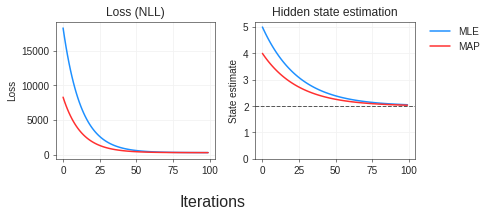

In [9]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1,2, facecolor=(1,1,1), figsize=(6, 3))

# Main plot
axes[0].plot(range(len(mle_loss)), mle_loss, c="#1e90ff")
axes[0].plot(range(len(map_loss)), map_loss, c="#ff3030")
axes[1].plot(range(len(mle_x)), mle_x, c="#1e90ff", label="MLE")
axes[1].plot(range(len(map_x)), map_x, c="#ff3030", label="MAP")

# Titles
axes[0].set_title("Loss (NLL)")
axes[1].set_title("Hidden state estimation")

# Axis labels
axes[0].set_ylabel("Loss")
axes[1].set_ylabel("State estimate")

# Hidden state estimate plot customization
axes[1].set_ylim([0, 5.2])
axes[1].axhline(y=2, linestyle="dashed", linewidth=1, c="#595959")

# Axis global labels
fig.supxlabel("Iterations", fontsize=16)

# Cosmetic changes 
for ax in axes:
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)

fig.legend(bbox_to_anchor=(1.14,0.9), loc='upper right', ncol=1)
fig.tight_layout()